# Model Training 

## Objectives
* Satisfy business rerquirement 2: *"The client is interested in predicting if a cherry tree is healthy or contains powdery mildew."*
    *  Engineer features for modelling
    *  Train a model
    
## Inputs
* inputs/cherry_leaves_dataset/train
* inputs/cherry_leaves_dataset/test
* inputs/cherry_leaves_dataset/validation
* image shape

## Outputs
* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file

___
### Import libraries

In [170]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from matplotlib.image import imread

### Set Working Directory
Change the working directory from its current folder to its parent folder.

In [2]:
current_dir = os.getcwd()
current_dir

'/Users/oksanaerm/ML/ML-mildew-detection/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/Users/oksanaerm/ML/ML-mildew-detection'

### Set input and output paths
***Inputs***

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

***Outputs***

In [6]:
version = 'v1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(current_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Create a new version")
    pass
else:
    os.makedirs(name=file_path)

version v1 already exists. Create a new version


### Set labels

In [7]:
labels = sorted(os.listdir(train_path))
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


### Set Image Shape

In [8]:
# Import saved image shape embedding
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

___
## Confirm Amount of Images to Train, Test and Validate Data
___

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




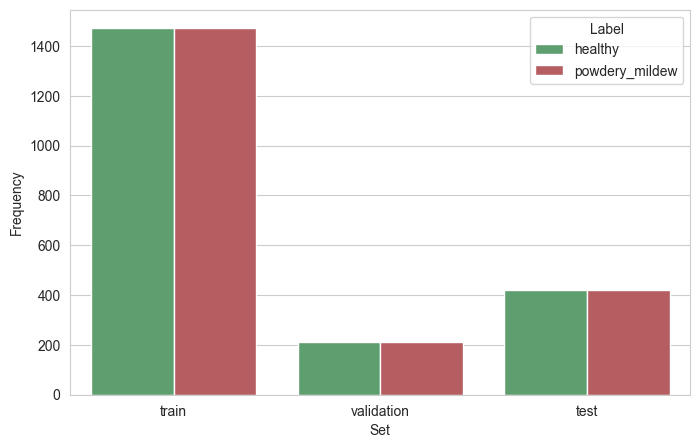

In [9]:
folders = ['train', 'validation', 'test']
# Generate the DataFrame of label frequencies using a list comprehension and os.scandir
df_freq = pd.DataFrame([{'Set': folder,
                         'Label': label,
                         'Frequency': sum(1 for _ in os.scandir(os.path.join(my_data_dir, folder, label)))}
                        for folder in folders
                        for label in labels])
# Print the label frequencies for each folder and label combination
for folder in folders:
    for label in labels:
        print(
            f"* {folder} - {label}: {df_freq[(df_freq['Set'] == folder) & (df_freq['Label'] == label)]['Frequency'].values[0]} images")
# Generate a stacked bar chart of the label frequencies using df_freq.groupby and plot
print("\n")
sns.set_style("whitegrid")
my_colors = ['#55A868', '#C44E52']
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency',
            hue='Label', palette=my_colors)
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


___
## Image Data Augmentation
As we see from the metrics above, the dataset is relatively small compared to some of the large-scale image datasets that are commonly used for training CNNs. That being said, it's not impossible to train a CNN with this dataset, but the model is going to be very prone to overfitting. To mitigate overfitting, you we will use data augmentation techniques to artificially increase the size of the training set.

#### Import DataImageGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-04-05 20:37:16.743636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Initialize DataImageGenerator

In [12]:
augmented_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

#### Loader Parameters

In [13]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

#### Augment Training Dataset Images

In [14]:
train_set = augmented_data.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode=data_color_mode,
                                               batch_size=batch_size,
                                               class_mode=data_class_mode,
                                               shuffle=True
                                               )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment Validation Dataset Images

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment Test Dataset Images 

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Plot Augmented Image

In [17]:
def plot_augmented_image(label_set, display_size=3):
    label_class = label_set.class_indices
    for _ in range(display_size):
        img, label = label_set.next()
        print(img.shape)
        img_class = list(label_class.keys())[
            list(label_class.values()).index(label[0])]
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(img_class)
        plt.show()

##### Training Image Set

(32, 256, 256, 3)


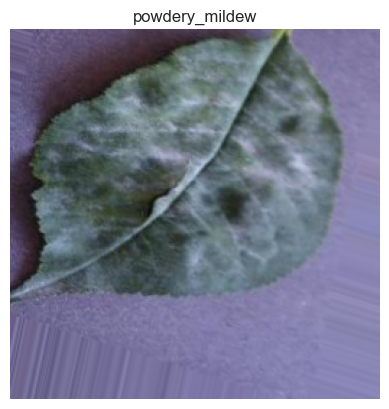

(32, 256, 256, 3)


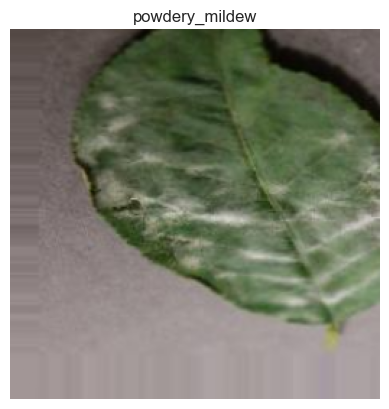

(32, 256, 256, 3)


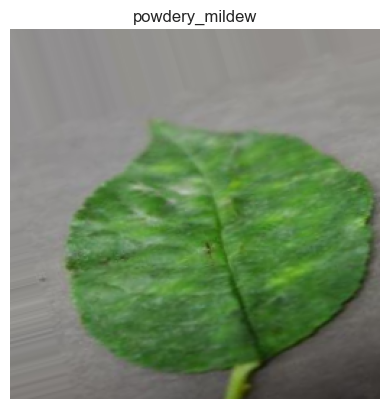

In [18]:
plot_augmented_image(train_set)

##### Validation Image Set

(32, 256, 256, 3)


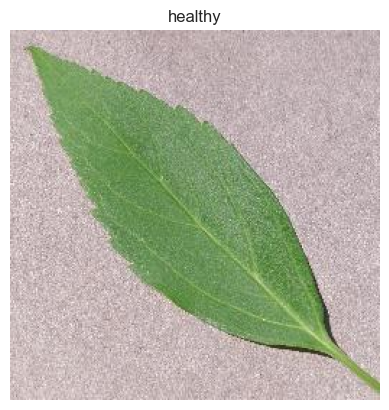

(32, 256, 256, 3)


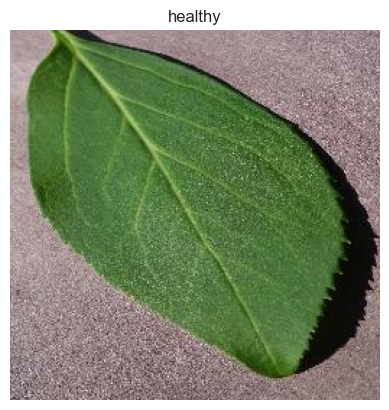

(32, 256, 256, 3)


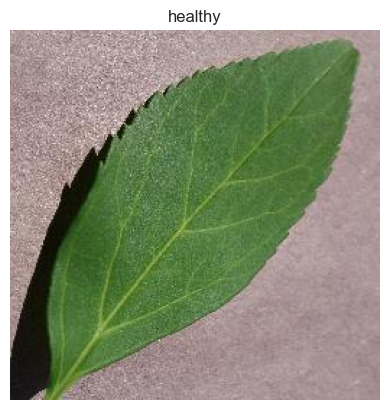

In [19]:
plot_augmented_image(validation_set)

##### Test Image Set

(32, 256, 256, 3)


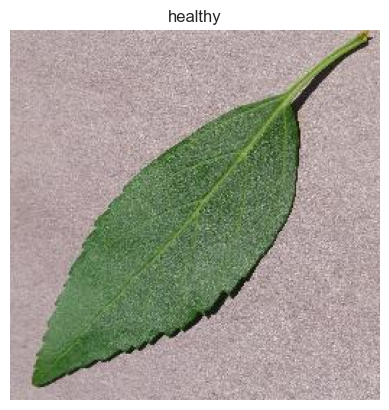

(32, 256, 256, 3)


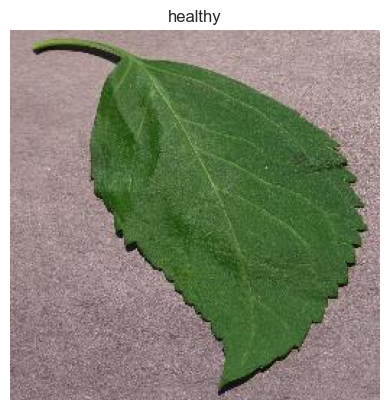

(32, 256, 256, 3)


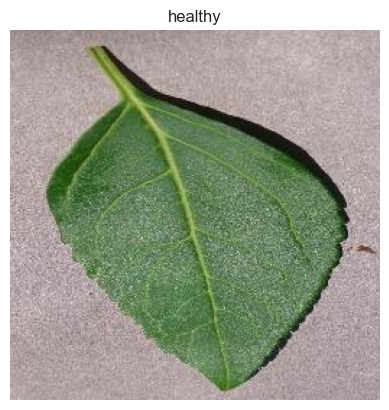

In [20]:
plot_augmented_image(test_set)

Save Class Indices

In [21]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")
train_set.class_indices


{'healthy': 0, 'powdery_mildew': 1}

___
## Creating the Model

Import ML packages

In [11]:
! pip install keras-tuner

In [25]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

Perameter definintions

In [22]:
EPOCHS = 20
OUTPUT_DIR = 'outputs/v1'

Builds models with varying hyperparameter configurations on which
hyperparameter optimisation is run.

In [51]:
def model_builder(hp):

    model = Sequential()

    model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=4, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    hp_units = hp.Int('units', min_value=8, max_value=64, step=8)
    model.add(Dense(units=hp_units, activation='relu',
              kernel_regularizer=l2(0.001)))

    model.add(Dropout(0.4))
    model.add(Dense(1, activation='tanh'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

Perform hyperparameter tuning, hyperband chosen as tuner, given its fast processing speed, early stopping and efficient resource utilization

In [52]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=file_path,
                     project_name='hypertuning'
                     )

Early stopping

In [53]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Calculate required class weight to handle target imbalance in data

In [55]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_set.classes),
    train_set.classes)

train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 1.0, 1: 1.0}

Search optimal hyperparameters

In [56]:
tuner.search(train_set,
             epochs=25,
             steps_per_epoch=len(train_set.classes) // batch_size,
             validation_data=validation_set,
             class_weight=train_class_weights,
             callbacks=[early_stop],
             verbose=2)

optimal_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the
first densely-connected layer is {optimal_hps.get('units')} and the optimal
learning rate for the optimizer is {optimal_hps.get('learning_rate')}.
""")

Trial 21 Complete [00h 03m 36s]
val_accuracy: 0.5

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 49m 32s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the
first densely-connected layer is 8 and the optimal
learning rate for the optimizer is 0.001.



Create model using optimal hyperparameters

In [57]:
model = tuner.hypermodel.build(optimal_hps)

Model summary

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 8)       584       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 4)         292       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 4)       

Fit the model

In [59]:
model.fit(train_set,
          epochs=EPOCHS,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          class_weight=train_class_weights,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/20
92/92 [==============================] - 50s 535ms/step - loss: 0.9809 - accuracy: 0.4844 - val_loss: 0.6127 - val_accuracy: 0.7286
Epoch 2/20
92/92 [==============================] - 55s 598ms/step - loss: 0.6517 - accuracy: 0.6797 - val_loss: 0.3136 - val_accuracy: 0.9167
Epoch 3/20
92/92 [==============================] - 54s 581ms/step - loss: 0.4583 - accuracy: 0.8115 - val_loss: 0.1783 - val_accuracy: 0.9405
Epoch 4/20
92/92 [==============================] - 53s 576ms/step - loss: 0.3325 - accuracy: 0.8777 - val_loss: 0.1146 - val_accuracy: 0.9786
Epoch 5/20
92/92 [==============================] - 53s 573ms/step - loss: 0.2820 - accuracy: 0.9090 - val_loss: 0.0814 - val_accuracy: 0.9952
Epoch 6/20
92/92 [==============================] - 51s 551ms/step - loss: 0.2277 - accuracy: 0.9324 - val_loss: 0.0798 - val_accuracy: 0.9905
Epoch 7/20
92/92 [==============================] - 50s 542ms/step - loss: 0.2200 - accuracy: 0.9331 - val_loss: 0.2209 - val_accuracy: 0.9214

Save the model

In [60]:
model.save(f'{OUTPUT_DIR}/mildew_detector_model.h5')

### Model performance

Model Learning Curve

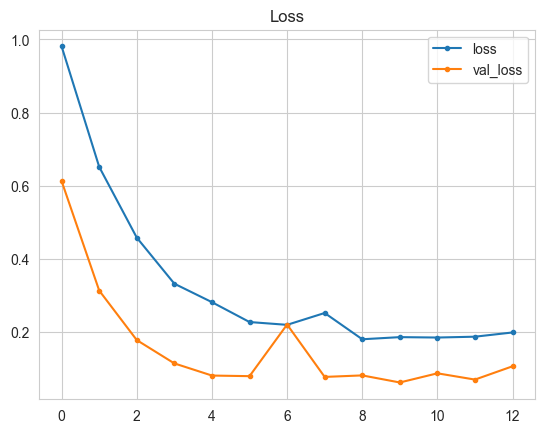

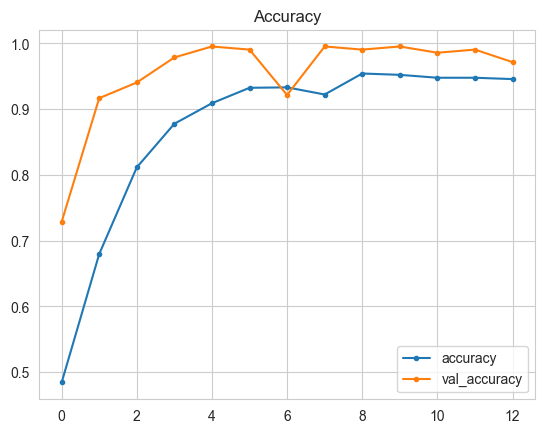

In [61]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model evaluation
Evaluation of the model on the test set

In [62]:
from keras.models import load_model
model = load_model(f'{OUTPUT_DIR}/mildew_detector_model.h5')

In [176]:
evaluation = model.evaluate(test_set)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))

27/27 [==============================] - 2s 66ms/step - loss: 0.1118 - accuracy: 0.9727
Model accuracy: 97.27%


* The performance on the test set meets the project requirements (at least 90% accuracy on test set) and answers Business Requirement #2

Save evaluation pickle

In [65]:
joblib.dump(value=evaluation, filename=f'{OUTPUT_DIR}/evaluation.pkl')

['outputs/v1/evaluation.pkl']

### ROC Curve

The ROC curve shows the relationship between the TPR and FPR for various classification thresholds. 

The AUC is a metric that measures the overall performance of the classifier.

27/27 [==============================] - 2s 68ms/step


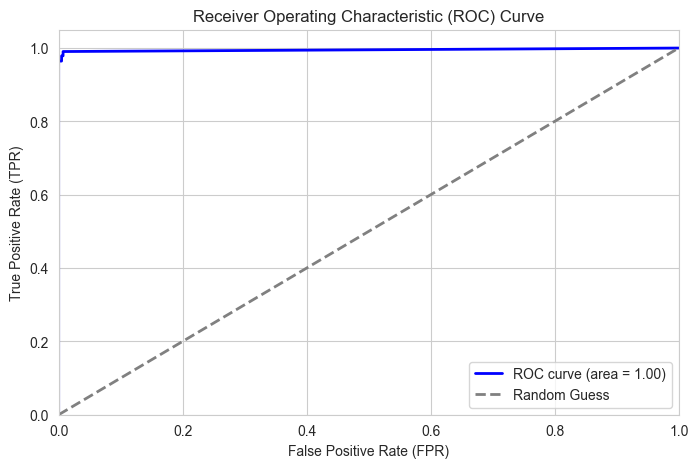

In [188]:
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set
y_pred = model.predict(test_set)

# Calculate FPR, TPR, and classification thresholds
fpr, tpr, thresholds = roc_curve(test_set.classes, y_pred)

# Calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2,
         linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(f'{file_path}/roc_curve.png', bbox_inches='tight', dpi=150)

### Confusion matrix

A classification report and a confusion matrix

                precision    recall  f1-score   support

       Healthy       0.95      1.00      0.97       422
Powdery Mildew       1.00      0.95      0.97       422

      accuracy                           0.97       844
     macro avg       0.97      0.97      0.97       844
  weighted avg       0.97      0.97      0.97       844



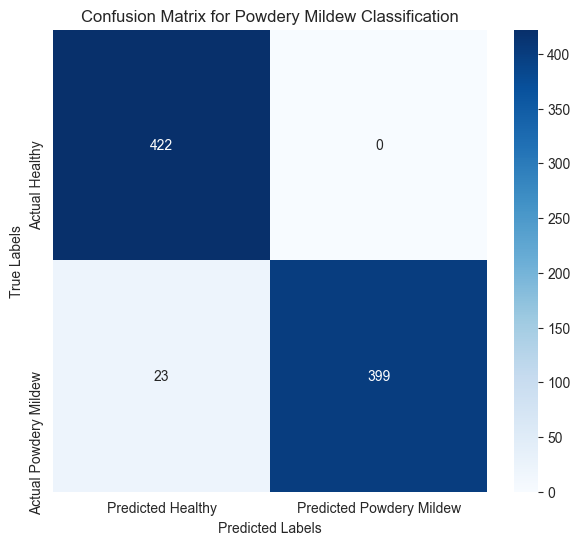

In [182]:
# Round the predictions and convert them to integers
y_pred = np.round(y_pred).astype(int)

target_names = ['Healthy', 'Powdery Mildew']
confusion_mat = confusion_matrix(test_set.classes, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mat,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=['Predicted Healthy', 'Predicted Powdery Mildew'],
            yticklabels=['Actual Healthy', 'Actual Powdery Mildew'])
plt.title('Confusion Matrix for Powdery Mildew Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight', dpi=150)

print(classification_report(test_set.classes, y_pred, target_names=target_names))


### Classification Report Plot

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib

def plot_classification_report(y_true, y_pred, title='Classification Report', target_names=None, save_fig_path=None, **kwargs):

    # Create a dictionary with classification report metrics
    clf_report = classification_report(y_true, y_pred, output_dict=True, **kwargs)
    
    # Convert dictionary to pandas dataframe and sort by support column
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    df = df.sort_values(by=['support'], ascending=True)

    # Define heatmap mask to show support column
    mask = np.zeros(df.shape)
    mask[:, -1] = True

    # Define heatmap colors and settings
    cmap = mpl.cm.YlGn
    norm = mpl.colors.Normalize(vmin=df['support'].min(), vmax=df['support'].sum())

    # Create heatmap with masked support column
    fig, ax = plt.subplots(figsize=(8, 5))
    ax = sns.heatmap(df, mask=mask, annot=True, cmap=cmap, fmt='.3g', cbar=False, linewidths=.4, linecolor='white', vmin=0.0, vmax=1.0)

    # Create heatmap with support column normalized colors
    mask = np.zeros(df.shape)
    mask[:, :-1] = True
    ax = sns.heatmap(df, mask=mask, annot=True, cmap=cmap, cbar=False, linewidths=2, linecolor='white', fmt='.0f', vmin=df['support'].min(), vmax=df['support'].sum(), norm=norm)

    # Set plot title and y-axis labels
    plt.title(title)
    if target_names is not None:
        classes = target_names
    else:
        classes = [str(i) for i in range(len(df.index))]
    plt.yticks(np.arange(len(classes))+.5, classes, rotation=0)

    # Save plot to file if save_fig_path is specified
    if save_fig_path is not None:
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)

    return fig, ax


## Predict on new data

Load random image

Image shape: (256, 256), Image mode: RGB


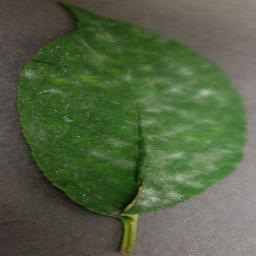

In [192]:
from tensorflow.keras.preprocessing import image

pointer = 32
label = labels[1]  
pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [193]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict

In [194]:
prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
predicted_class = target_map[prediction_probability > 0.5]
if predicted_class == target_map[0]:
    prediction_probability = 1 - prediction_probability

print(f'Prediction probability: {round(prediction_probability*100, 2)}%')
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 31ms/step
Prediction probability: 99.73%
Predicted class: powdery_mildew
